In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b10_b25_b50_b75_t1_mask_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 460)
(734160, 1)
validation
(101248, 460)
(101248, 1)
test
(100432, 460)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1161217 (4.43 MB)


Trainable params: 1161217 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:23 - loss: 0.0228 - STD: 7.7860e-05 - MAE: 0.1344

 5/74 [=>............................] - ETA: 0s - loss: 0.0188 - STD: 6.2708e-05 - MAE: 0.1074  

 9/74 [==>...........................] - ETA: 0s - loss: 0.0157 - STD: 5.2660e-05 - MAE: 0.0960

13/74 [====>.........................] - ETA: 3s - loss: 0.0147 - STD: 5.0291e-05 - MAE: 0.0951

18/74 [======>.......................] - ETA: 2s - loss: 0.0134 - STD: 4.6829e-05 - MAE: 0.0896

23/74 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 4.6130e-05 - MAE: 0.0865

28/74 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 4.7996e-05 - MAE: 0.0856

33/74 [============>.................] - ETA: 1s - loss: 0.0117 - STD: 4.9362e-05 - MAE: 0.0840

38/74 [==============>...............] - ETA: 0s - loss: 0.0114 - STD: 5.1188e-05 - MAE: 0.0828

43/74 [================>.............] - ETA: 0s - loss: 0.0112 - STD: 5.3973e-05 - MAE: 0.0821

48/74 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 5.6621e-05 - MAE: 0.0813

53/74 [====================>.........] - ETA: 0s - loss: 0.0108 - STD: 5.9739e-05 - MAE: 0.0807

58/74 [======================>.......] - ETA: 0s - loss: 0.0107 - STD: 6.3352e-05 - MAE: 0.0803

62/74 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 6.6276e-05 - MAE: 0.0800

66/74 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 6.9483e-05 - MAE: 0.0797

71/74 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 7.3864e-05 - MAE: 0.0794

74/74 [==============================] - 3s 28ms/step - loss: 0.0103 - STD: 7.6637e-05 - MAE: 0.0793 - val_loss: 0.0086 - val_STD: 1.1417e-04 - val_MAE: 0.0713


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0091 - STD: 1.4811e-04 - MAE: 0.0745

 5/74 [=>............................] - ETA: 0s - loss: 0.0091 - STD: 1.5346e-04 - MAE: 0.0748

 9/74 [==>...........................] - ETA: 0s - loss: 0.0092 - STD: 1.6063e-04 - MAE: 0.0752

14/74 [====>.........................] - ETA: 0s - loss: 0.0092 - STD: 1.6928e-04 - MAE: 0.0753

19/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 1.7873e-04 - MAE: 0.0752

23/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 1.8668e-04 - MAE: 0.0752

27/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.9544e-04 - MAE: 0.0752

32/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 2.0698e-04 - MAE: 0.0752

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 2.1967e-04 - MAE: 0.0752

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 2.3361e-04 - MAE: 0.0752

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 2.4900e-04 - MAE: 0.0752

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 2.6275e-04 - MAE: 0.0752

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 2.8158e-04 - MAE: 0.0752

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.0245e-04 - MAE: 0.0753

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.2682e-04 - MAE: 0.0753

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.5411e-04 - MAE: 0.0753

74/74 [==============================] - 1s 14ms/step - loss: 0.0092 - STD: 3.7268e-04 - MAE: 0.0753 - val_loss: 0.0085 - val_STD: 6.7726e-04 - val_MAE: 0.0715


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0092 - STD: 8.6608e-04 - MAE: 0.0752

 6/74 [=>............................] - ETA: 0s - loss: 0.0090 - STD: 9.3128e-04 - MAE: 0.0746

11/74 [===>..........................] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0748    

16/74 [=====>........................] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

21/74 [=======>......................] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0752

25/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0753

29/74 [==========>...................] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0752

34/74 [============>.................] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0752

39/74 [==============>...............] - ETA: 0s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0750

44/74 [================>.............] - ETA: 0s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0749

49/74 [==================>...........] - ETA: 0s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0747

54/74 [====================>.........] - ETA: 0s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0745

58/74 [======================>.......] - ETA: 0s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0743

62/74 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0046 - MAE: 0.0741

67/74 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0737

71/74 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0733

74/74 [==============================] - 1s 14ms/step - loss: 0.0086 - STD: 0.0079 - MAE: 0.0730 - val_loss: 0.0060 - val_STD: 0.0301 - val_MAE: 0.0601


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0365 - MAE: 0.0653

 5/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0399 - MAE: 0.0639

10/74 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0438 - MAE: 0.0638

15/74 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0461 - MAE: 0.0636

20/74 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0480 - MAE: 0.0639

24/74 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0486 - MAE: 0.0637

28/74 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0489 - MAE: 0.0635

33/74 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0491 - MAE: 0.0632

38/74 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0494 - MAE: 0.0630

43/74 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0498 - MAE: 0.0628

48/74 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0503 - MAE: 0.0627

53/74 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0508 - MAE: 0.0625

57/74 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0510 - MAE: 0.0625

61/74 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0624

66/74 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0515 - MAE: 0.0623

71/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0517 - MAE: 0.0622

74/74 [==============================] - 1s 14ms/step - loss: 0.0064 - STD: 0.0517 - MAE: 0.0622 - val_loss: 0.0057 - val_STD: 0.0439 - val_MAE: 0.0565


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0619

 5/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0614

10/74 [===>..........................] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0611

15/74 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0610

20/74 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0611

25/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0610

30/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0610

34/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0609

38/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0609

43/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0609

48/74 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0609

53/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0609

58/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0609

63/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0610

67/74 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0610

72/74 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0610

74/74 [==============================] - 1s 14ms/step - loss: 0.0062 - STD: 0.0544 - MAE: 0.0610 - val_loss: 0.0056 - val_STD: 0.0460 - val_MAE: 0.0562


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0552 - MAE: 0.0620

 5/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0610

10/74 [===>..........................] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0609

15/74 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0608

20/74 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0608

25/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0607

30/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0607

34/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0608

38/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0608

43/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0608

48/74 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0608

53/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0608

58/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0608

63/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0607

67/74 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0607

71/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0608

74/74 [==============================] - 1s 14ms/step - loss: 0.0062 - STD: 0.0548 - MAE: 0.0607 - val_loss: 0.0056 - val_STD: 0.0463 - val_MAE: 0.0563


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0561 - MAE: 0.0625

 6/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0605

10/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0606

15/74 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0606

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0606

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0606

30/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0606

35/74 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0606

39/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0606

44/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0606

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0606

54/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0605

59/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0606

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0606

69/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0606

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0606

74/74 [==============================] - 1s 14ms/step - loss: 0.0061 - STD: 0.0550 - MAE: 0.0606 - val_loss: 0.0056 - val_STD: 0.0455 - val_MAE: 0.0556


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0544 - MAE: 0.0605

 5/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0547 - MAE: 0.0601

10/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0606

15/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0606

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0605

24/74 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0605

29/74 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0605

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0605

39/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0605

44/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0604

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0604

54/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0604

58/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0604

63/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0604

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0603

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0603

74/74 [==============================] - 1s 14ms/step - loss: 0.0061 - STD: 0.0554 - MAE: 0.0603 - val_loss: 0.0056 - val_STD: 0.0459 - val_MAE: 0.0554


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0601

 6/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0602

11/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0605

16/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0603

21/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0603

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0602

29/74 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0603

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0604

39/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0606

43/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0607

48/74 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0608

53/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0607

57/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0607

61/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0607

66/74 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0606

71/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0606

74/74 [==============================] - 1s 14ms/step - loss: 0.0061 - STD: 0.0549 - MAE: 0.0606 - val_loss: 0.0055 - val_STD: 0.0463 - val_MAE: 0.0557


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0556 - MAE: 0.0617

 5/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0608

10/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0605

15/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0602

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0602

25/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0601

30/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

34/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

39/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0600

44/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0600

49/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0601

54/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0601

59/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0601

63/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0601

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0601

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0601

74/74 [==============================] - 1s 14ms/step - loss: 0.0061 - STD: 0.0558 - MAE: 0.0601 - val_loss: 0.0054 - val_STD: 0.0475 - val_MAE: 0.0553


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0604

 5/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0601

10/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0604

14/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0605

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0604

24/74 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0604

29/74 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0604

33/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0603

38/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0603

43/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0602

48/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0602

53/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

58/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

66/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

70/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601

74/74 [==============================] - 1s 14ms/step - loss: 0.0060 - STD: 0.0559 - MAE: 0.0601 - val_loss: 0.0057 - val_STD: 0.0449 - val_MAE: 0.0553


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0591

 6/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0597

10/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0597

14/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0597

18/74 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0597

23/74 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0597

28/74 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

33/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0598

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0598

42/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0598

47/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0598

52/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0597

57/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0598

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0599

67/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0599

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

74/74 [==============================] - 1s 14ms/step - loss: 0.0060 - STD: 0.0559 - MAE: 0.0600 - val_loss: 0.0057 - val_STD: 0.0435 - val_MAE: 0.0552


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0528 - MAE: 0.0593

 5/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0551 - MAE: 0.0598

10/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0597

14/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0597

19/74 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0599

24/74 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0599

29/74 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0599

34/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0599

39/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0599

44/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0599

48/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0600

53/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

58/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

63/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

73/74 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0600

74/74 [==============================] - 1s 14ms/step - loss: 0.0060 - STD: 0.0559 - MAE: 0.0600 - val_loss: 0.0054 - val_STD: 0.0476 - val_MAE: 0.0562


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0570 - MAE: 0.0614

 5/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0600

10/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0600

15/74 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0599

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0601

24/74 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0601

28/74 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0600

32/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0600

37/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0600

41/74 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

46/74 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0600

51/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0600

55/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0599

59/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0599

64/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0599

69/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0599

74/74 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0598

74/74 [==============================] - 1s 14ms/step - loss: 0.0060 - STD: 0.0563 - MAE: 0.0598 - val_loss: 0.0053 - val_STD: 0.0487 - val_MAE: 0.0547


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0591 - MAE: 0.0607

 6/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0574 - MAE: 0.0598

11/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0598

16/74 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0596

21/74 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0596

25/74 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0596

29/74 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0596

33/74 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0596

38/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0596

43/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0596

48/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0596

53/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0596

58/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0597

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0597

66/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0598

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0598

74/74 [==============================] - 1s 14ms/step - loss: 0.0060 - STD: 0.0562 - MAE: 0.0599 - val_loss: 0.0053 - val_STD: 0.0478 - val_MAE: 0.0551


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0567 - MAE: 0.0616

 5/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0575 - MAE: 0.0612

10/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0605

15/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0605

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0603

25/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0602

30/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0600

34/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0600

39/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0600

44/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0599

49/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0599

54/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0598

59/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0598

64/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0597

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0597

73/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0597

74/74 [==============================] - 1s 14ms/step - loss: 0.0059 - STD: 0.0568 - MAE: 0.0597 - val_loss: 0.0053 - val_STD: 0.0476 - val_MAE: 0.0543


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0591

 6/74 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0592

10/74 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593

14/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0594

19/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593

24/74 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593

29/74 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0593

34/74 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0593

39/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593

43/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0593

48/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0592

53/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0593

58/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0593

63/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0593

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0593

72/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0594

74/74 [==============================] - 1s 14ms/step - loss: 0.0059 - STD: 0.0573 - MAE: 0.0593 - val_loss: 0.0053 - val_STD: 0.0471 - val_MAE: 0.0541


Epoch 18/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0589

 5/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0589

10/74 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0588

14/74 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0589

18/74 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0590

23/74 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0590

28/74 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0591

33/74 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0591

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0590

47/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0591

51/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

61/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0591

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0591

71/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0591

74/74 [==============================] - 1s 14ms/step - loss: 0.0058 - STD: 0.0577 - MAE: 0.0591 - val_loss: 0.0053 - val_STD: 0.0483 - val_MAE: 0.0539


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0593

 5/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0589

 9/74 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0590

14/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0592

19/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0592

24/74 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0592

29/74 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0591

33/74 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

48/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0591

53/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0591

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0590

63/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0590

67/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0590

72/74 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0590

74/74 [==============================] - 1s 14ms/step - loss: 0.0058 - STD: 0.0577 - MAE: 0.0590 - val_loss: 0.0052 - val_STD: 0.0513 - val_MAE: 0.0547


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0602

 5/74 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0595

 9/74 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0595

14/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0596

19/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0566 - MAE: 0.0596

24/74 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0594

29/74 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0595

34/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0597

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0597

42/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0562 - MAE: 0.0596

47/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0595

52/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0595

57/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0594

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0594

66/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0594

70/74 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593

74/74 [==============================] - 1s 14ms/step - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593 - val_loss: 0.0052 - val_STD: 0.0492 - val_MAE: 0.0538


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0595

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0587

10/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0586

14/74 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0587

19/74 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0587

24/74 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0589

29/74 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

33/74 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0578 - MAE: 0.0592

38/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0592

42/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0592

47/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0593

52/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593

57/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0593

61/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0593

66/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0592

71/74 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0592

74/74 [==============================] - 1s 14ms/step - loss: 0.0059 - STD: 0.0572 - MAE: 0.0591 - val_loss: 0.0052 - val_STD: 0.0486 - val_MAE: 0.0536


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0568 - MAE: 0.0586

 5/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0573 - MAE: 0.0583

 9/74 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0581

14/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0581

19/74 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

24/74 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

29/74 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

33/74 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

37/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

41/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

46/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0585

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0585

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0585

74/74 [==============================] - 1s 14ms/step - loss: 0.0057 - STD: 0.0584 - MAE: 0.0585 - val_loss: 0.0052 - val_STD: 0.0497 - val_MAE: 0.0534


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0583

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0585

10/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

14/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0585

19/74 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0583

24/74 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0583

29/74 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

34/74 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0584

39/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0583

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0584

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0584

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

58/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0584

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

74/74 [==============================] - 1s 14ms/step - loss: 0.0057 - STD: 0.0585 - MAE: 0.0583 - val_loss: 0.0051 - val_STD: 0.0531 - val_MAE: 0.0538


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0608 - MAE: 0.0591

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0584

11/74 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0585

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

20/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0584

25/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

30/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0583

35/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0583

40/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

45/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0582

50/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0583

60/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0584

65/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

69/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0585

74/74 [==============================] - 1s 14ms/step - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584 - val_loss: 0.0053 - val_STD: 0.0477 - val_MAE: 0.0531


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0547 - MAE: 0.0579

 5/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0589

 9/74 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

17/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0584

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0583

25/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0582

30/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0582

35/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0582

40/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0582

45/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0582

50/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

60/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

65/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

74/74 [==============================] - 1s 14ms/step - loss: 0.0057 - STD: 0.0590 - MAE: 0.0581 - val_loss: 0.0051 - val_STD: 0.0509 - val_MAE: 0.0529


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0572

 5/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0578

 9/74 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0580

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

17/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0580

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0580

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0580

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0580

35/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

39/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0579

43/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

47/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

52/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578

57/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0579

74/74 [==============================] - 1s 14ms/step - loss: 0.0057 - STD: 0.0593 - MAE: 0.0580 - val_loss: 0.0052 - val_STD: 0.0481 - val_MAE: 0.0528


Epoch 27/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0547 - MAE: 0.0578

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0582

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0580

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0580

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

30/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0581

34/74 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0582

39/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0583

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0583

57/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0582

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0582

67/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

74/74 [==============================] - 1s 14ms/step - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581 - val_loss: 0.0051 - val_STD: 0.0502 - val_MAE: 0.0527


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0571 - MAE: 0.0575

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0588

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0584

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0582

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0581

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

36/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

70/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

74/74 [==============================] - 1s 14ms/step - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577 - val_loss: 0.0051 - val_STD: 0.0511 - val_MAE: 0.0525


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0563

 5/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0572

 9/74 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0574

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0575

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0575

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0575

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0576

30/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0576

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0576

38/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0578

42/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

47/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

55/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

63/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

68/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

74/74 [==============================] - 1s 15ms/step - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577 - val_loss: 0.0051 - val_STD: 0.0509 - val_MAE: 0.0524


Epoch 30/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0565

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0575

 9/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0589 - MAE: 0.0575

14/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0573

18/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0575

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

35/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0578

39/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

44/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578

48/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578

52/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0578

57/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0578

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

65/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0578

74/74 [==============================] - 1s 15ms/step - loss: 0.0056 - STD: 0.0592 - MAE: 0.0578 - val_loss: 0.0050 - val_STD: 0.0550 - val_MAE: 0.0532


Epoch 31/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0617 - MAE: 0.0589

 5/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0578

 9/74 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0577

14/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0576

18/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0578

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0577

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0577

30/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

38/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

42/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0575

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0575

50/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0575

54/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

58/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0574

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0574

74/74 [==============================] - 1s 15ms/step - loss: 0.0056 - STD: 0.0599 - MAE: 0.0574 - val_loss: 0.0051 - val_STD: 0.0518 - val_MAE: 0.0524


Epoch 32/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0560

 5/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0576

 9/74 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0575

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0574

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0573

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0573

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0573

30/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0573

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0573

38/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

42/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

50/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0573

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

74/74 [==============================] - 1s 14ms/step - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572 - val_loss: 0.0050 - val_STD: 0.0548 - val_MAE: 0.0522


Epoch 33/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0568

 5/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0578

10/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0576

14/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0575

18/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0575

23/74 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0574

28/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

33/74 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0578

38/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0578

42/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578

50/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

54/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0578

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0577

64/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0576

74/74 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

74/74 [==============================] - 1s 14ms/step - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576 - val_loss: 0.0050 - val_STD: 0.0531 - val_MAE: 0.0522


Epoch 34/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0566

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0570

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0571

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0571

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0570

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0570

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0570

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

40/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0569

44/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0569

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

64/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

69/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

74/74 [==============================] - 1s 14ms/step - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569 - val_loss: 0.0054 - val_STD: 0.0530 - val_MAE: 0.0532


Epoch 35/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0565

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0596 - MAE: 0.0582

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0578

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0578

20/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0577

24/74 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0578

28/74 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0577

32/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0577

37/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0577

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0576

45/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0575

49/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0575

54/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0574

58/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0574

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0573

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0573

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0573

74/74 [==============================] - 1s 15ms/step - loss: 0.0056 - STD: 0.0599 - MAE: 0.0572 - val_loss: 0.0049 - val_STD: 0.0557 - val_MAE: 0.0520


Epoch 36/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0594 - MAE: 0.0570

 5/74 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0569

 9/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0568

14/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0567

18/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0567

23/74 [========>.....................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0567

28/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

33/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0566

38/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0566

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0566

47/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0566

63/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

67/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0566

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0566

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0609 - MAE: 0.0566 - val_loss: 0.0049 - val_STD: 0.0591 - val_MAE: 0.0528


Epoch 37/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0574

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0566

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0565

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0565

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565

33/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0564

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0564

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0564

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0565

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0566

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0566

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0566

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0566

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0568

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0606 - MAE: 0.0568 - val_loss: 0.0049 - val_STD: 0.0554 - val_MAE: 0.0515


Epoch 38/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0558

 5/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0605 - MAE: 0.0563

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0605 - MAE: 0.0563

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0563

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0563

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

34/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

38/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

48/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0564

52/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0563

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0565

68/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0565

72/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0566

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567 - val_loss: 0.0048 - val_STD: 0.0515 - val_MAE: 0.0518


Epoch 39/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0553 - MAE: 0.0573

 5/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0569

 9/74 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0572

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0571

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0571

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0569

30/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0568

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0568

38/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0568

43/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0567

47/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

52/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0566

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0566

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565 - val_loss: 0.0049 - val_STD: 0.0573 - val_MAE: 0.0516


Epoch 40/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0628 - MAE: 0.0562

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0558

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0560

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0560

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0561

22/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

27/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0560

32/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0560

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0560

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0560

44/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0560

48/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0560

52/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0560

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0560

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

68/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

73/74 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561 - val_loss: 0.0048 - val_STD: 0.0579 - val_MAE: 0.0515


Epoch 41/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0564

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0562

10/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0565

14/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0569

18/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0574

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0574

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0573

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0572

35/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0572

39/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0571

43/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0571

47/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0570

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

55/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

72/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0568

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567 - val_loss: 0.0048 - val_STD: 0.0548 - val_MAE: 0.0517


Epoch 42/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0564

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

10/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0561

14/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

23/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0562

27/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

32/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

40/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0560

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560 - val_loss: 0.0048 - val_STD: 0.0557 - val_MAE: 0.0512


Epoch 43/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0591 - MAE: 0.0557

 5/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0558

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0559

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0560

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0559

22/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0561

27/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

32/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0562

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0562

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0561

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0561

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561 - val_loss: 0.0048 - val_STD: 0.0592 - val_MAE: 0.0513


Epoch 44/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0560

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

10/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0556

14/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

19/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

28/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

32/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

44/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

48/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0559

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0559

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0619 - MAE: 0.0559 - val_loss: 0.0048 - val_STD: 0.0552 - val_MAE: 0.0511


Epoch 45/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0548

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0556

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0556

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0556

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0556

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0556

27/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0556

32/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557 - val_loss: 0.0047 - val_STD: 0.0593 - val_MAE: 0.0512


Epoch 46/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0553

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

22/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

39/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

43/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

47/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556 - val_loss: 0.0047 - val_STD: 0.0576 - val_MAE: 0.0509


Epoch 47/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0551

 5/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0552

 9/74 [==>...........................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0552

14/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0551

18/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0551

23/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0552

28/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0553

32/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0554

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555 - val_loss: 0.0047 - val_STD: 0.0584 - val_MAE: 0.0512


Epoch 48/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0625 - MAE: 0.0543

 5/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

10/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0553

14/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0553

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

22/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0554

27/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

44/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

48/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555 - val_loss: 0.0047 - val_STD: 0.0575 - val_MAE: 0.0507


Epoch 49/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0551

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0559

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0559

30/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

34/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0557

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

43/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

47/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0564

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0565

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0565

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

74/74 [==============================] - 1s 14ms/step - loss: 0.0055 - STD: 0.0608 - MAE: 0.0566 - val_loss: 0.0049 - val_STD: 0.0526 - val_MAE: 0.0515


Epoch 50/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0563 - MAE: 0.0548

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0555

10/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0555

14/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0556

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0556

22/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0555

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0555

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0555

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0555

39/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

43/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

47/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0555

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0555

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555 - val_loss: 0.0048 - val_STD: 0.0581 - val_MAE: 0.0508


Epoch 51/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0546

 5/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0549

10/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0552

14/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0551

18/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0551

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

27/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0555

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

44/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

48/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554 - val_loss: 0.0047 - val_STD: 0.0593 - val_MAE: 0.0511


Epoch 52/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0557

 5/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0553

 9/74 [==>...........................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0552

13/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0553

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0553

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0553

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0553

30/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0553

34/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0553

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0552

43/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

47/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0552

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

59/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

63/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0552

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0552

74/74 [==============================] - 1s 15ms/step - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552 - val_loss: 0.0046 - val_STD: 0.0585 - val_MAE: 0.0507


Epoch 53/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0617 - MAE: 0.0543

 5/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0552

10/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0549

15/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

19/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

24/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549

29/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

34/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

44/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0550

49/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551

54/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0552

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0553

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0553

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554 - val_loss: 0.0048 - val_STD: 0.0625 - val_MAE: 0.0521


Epoch 54/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0563

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0553

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0552

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0553

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0552

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0551

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

65/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

70/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

74/74 [==============================] - 1s 13ms/step - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551 - val_loss: 0.0047 - val_STD: 0.0625 - val_MAE: 0.0513


Epoch 55/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0541

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0547

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0631 - MAE: 0.0548

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

21/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

60/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549

65/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549

70/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549

74/74 [==============================] - 1s 14ms/step - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549 - val_loss: 0.0046 - val_STD: 0.0599 - val_MAE: 0.0505


Epoch 56/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0540

 5/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

10/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0549

15/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0547

20/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

25/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

30/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

60/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

65/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

70/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

74/74 [==============================] - 1s 13ms/step - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549 - val_loss: 0.0049 - val_STD: 0.0575 - val_MAE: 0.0512


Epoch 57/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0552

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0552

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0551

21/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0550

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0550

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0550

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0550

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0550

74/74 [==============================] - 1s 13ms/step - loss: 0.0052 - STD: 0.0628 - MAE: 0.0550 - val_loss: 0.0046 - val_STD: 0.0597 - val_MAE: 0.0505


Epoch 58/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0535

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0627 - MAE: 0.0546

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

21/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0550

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0550

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

74/74 [==============================] - 1s 13ms/step - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551 - val_loss: 0.0046 - val_STD: 0.0542 - val_MAE: 0.0505


Epoch 59/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0571 - MAE: 0.0547

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0552

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0551

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0553

21/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0552

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0550

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0550

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0549

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

74/74 [==============================] - 1s 13ms/step - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547 - val_loss: 0.0047 - val_STD: 0.0615 - val_MAE: 0.0517


Epoch 60/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0648 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0547

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0546

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0548

21/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0547

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0548

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0547

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0547

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0547

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0547

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

71/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

74/74 [==============================] - 1s 13ms/step - loss: 0.0051 - STD: 0.0634 - MAE: 0.0546 - val_loss: 0.0046 - val_STD: 0.0555 - val_MAE: 0.0504


Epoch 61/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0541

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0547

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0548

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0553

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0552

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0552

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0552

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0551

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0551

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0551

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0550

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0550

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549

74/74 [==============================] - 1s 13ms/step - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548 - val_loss: 0.0046 - val_STD: 0.0622 - val_MAE: 0.0509


Epoch 62/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0542

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0546

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0548

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0548

21/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0550

26/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0551

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0551

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0550

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0550

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

74/74 [==============================] - 1s 14ms/step - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548 - val_loss: 0.0046 - val_STD: 0.0612 - val_MAE: 0.0506


Epoch 63/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0538

 5/74 [=>............................] - ETA: 0s - loss: 0.0050 - STD: 0.0639 - MAE: 0.0540

10/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

15/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0543

20/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0545

25/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

30/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0544

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0544

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0544

45/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0544

50/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0543

55/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0543

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0543

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

70/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544 - val_loss: 0.0047 - val_STD: 0.0629 - val_MAE: 0.0514


Epoch 64/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0544

 5/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0544

 9/74 [==>...........................] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0543

14/74 [====>.........................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0545

19/74 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

24/74 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0544

29/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0543

34/74 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0542

39/74 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0543

44/74 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

49/74 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

54/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

58/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

63/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

68/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

73/74 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544 - val_loss: 0.0047 - val_STD: 0.0627 - val_MAE: 0.0516


Epoch 65/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0554

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0546

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0544

16/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0544

21/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0545

26/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0545

31/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0545

36/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0545

41/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

46/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

51/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

56/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

71/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544 - val_loss: 0.0048 - val_STD: 0.0643 - val_MAE: 0.0524


Epoch 66/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0050 - STD: 0.0646 - MAE: 0.0540

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0541

16/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

21/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

26/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

31/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

36/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

41/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

46/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

51/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

56/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0543

71/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0543

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0637 - MAE: 0.0543 - val_loss: 0.0046 - val_STD: 0.0599 - val_MAE: 0.0505


Epoch 67/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0537

 5/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

10/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0545

15/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0545

20/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0553

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0555

35/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0558

40/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0557

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0556

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0555

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0554

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0553

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0552

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0551

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0623 - MAE: 0.0551 - val_loss: 0.0047 - val_STD: 0.0642 - val_MAE: 0.0509


Epoch 68/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0541

 6/74 [=>............................] - ETA: 0s - loss: 0.0050 - STD: 0.0636 - MAE: 0.0541

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0542

15/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0543

20/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0544

25/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0547

30/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0549

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

60/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

64/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

69/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0546

74/74 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0546

74/74 [==============================] - 1s 14ms/step - loss: 0.0052 - STD: 0.0632 - MAE: 0.0546 - val_loss: 0.0046 - val_STD: 0.0584 - val_MAE: 0.0503


Epoch 69/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0602 - MAE: 0.0530

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0542

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

16/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0542

21/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

25/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0542

30/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

44/74 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

49/74 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

54/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

59/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

69/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

74/74 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0639 - MAE: 0.0542 - val_loss: 0.0046 - val_STD: 0.0639 - val_MAE: 0.0510


Epoch 70/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0544

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0539

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0540

16/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

21/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

26/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0542

30/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0543

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0543

45/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

50/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

55/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0542

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

70/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541 - val_loss: 0.0048 - val_STD: 0.0661 - val_MAE: 0.0519


Epoch 71/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0550

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0541

11/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0541

16/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0541

20/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0541

25/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

30/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0540

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0540

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0541

45/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

50/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

55/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

59/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

69/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0540

74/74 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541 - val_loss: 0.0049 - val_STD: 0.0659 - val_MAE: 0.0530


Epoch 72/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0544

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0543

11/74 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0635 - MAE: 0.0540

16/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0540

20/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0541

25/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0541

30/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0541

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0542

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0543

44/74 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0543

49/74 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0544

54/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545

59/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0545

64/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0545

69/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0545

74/74 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

74/74 [==============================] - 1s 14ms/step - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545 - val_loss: 0.0047 - val_STD: 0.0635 - val_MAE: 0.0513


Epoch 73/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0551

 5/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0545

10/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

15/74 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0541

20/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

25/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

30/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0540

39/74 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0540

44/74 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0540

49/74 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0540

54/74 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0539

59/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0539

63/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0539

68/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0539

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0540

74/74 [==============================] - 1s 14ms/step - loss: 0.0050 - STD: 0.0641 - MAE: 0.0540 - val_loss: 0.0049 - val_STD: 0.0648 - val_MAE: 0.0533


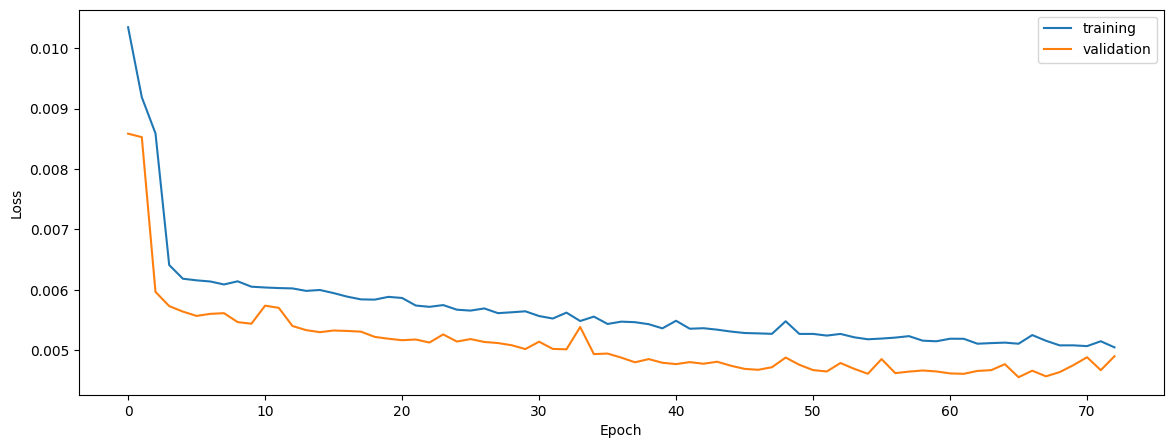

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.672717646318407
0.6879880526425486
0.6692691688544928


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.672717646318407
0.6879880526425486
0.6692691688544928


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.6670674130888026
0.6879875365864241
0.6607929894070368


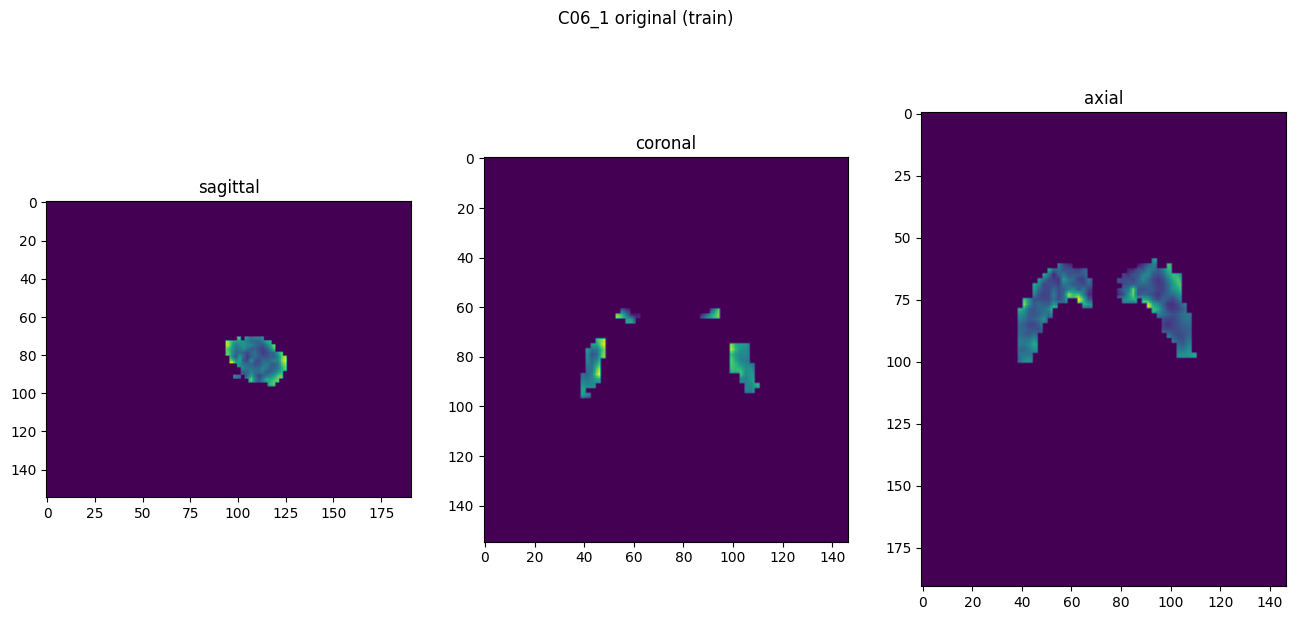

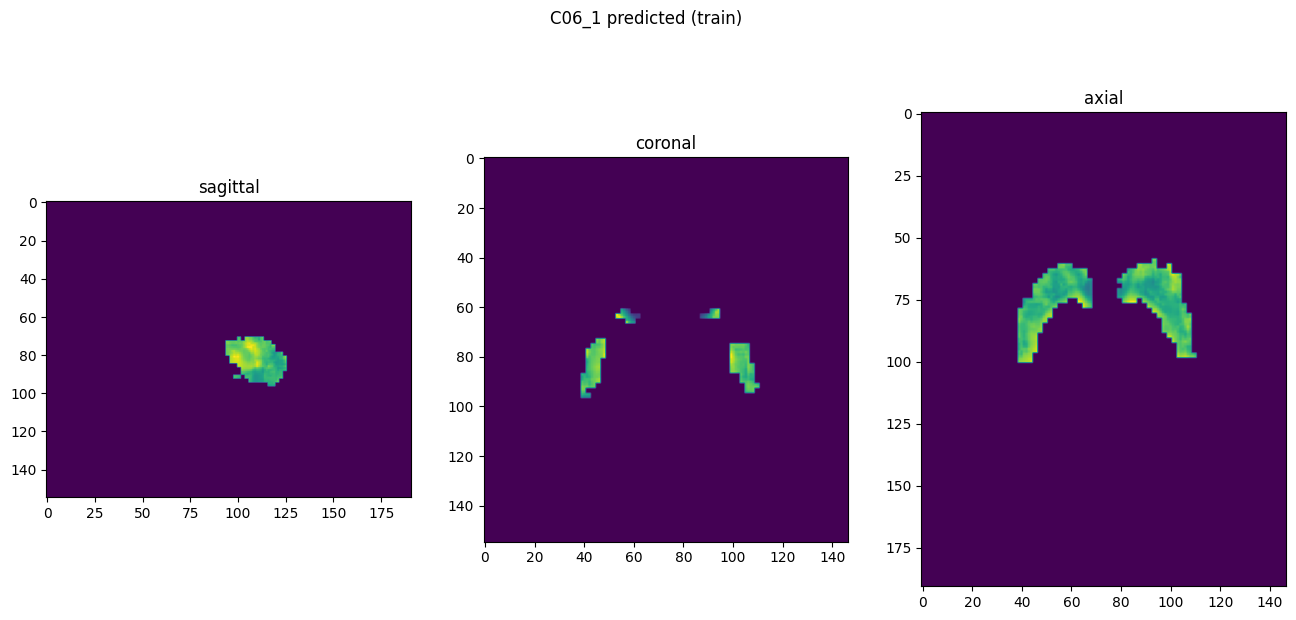

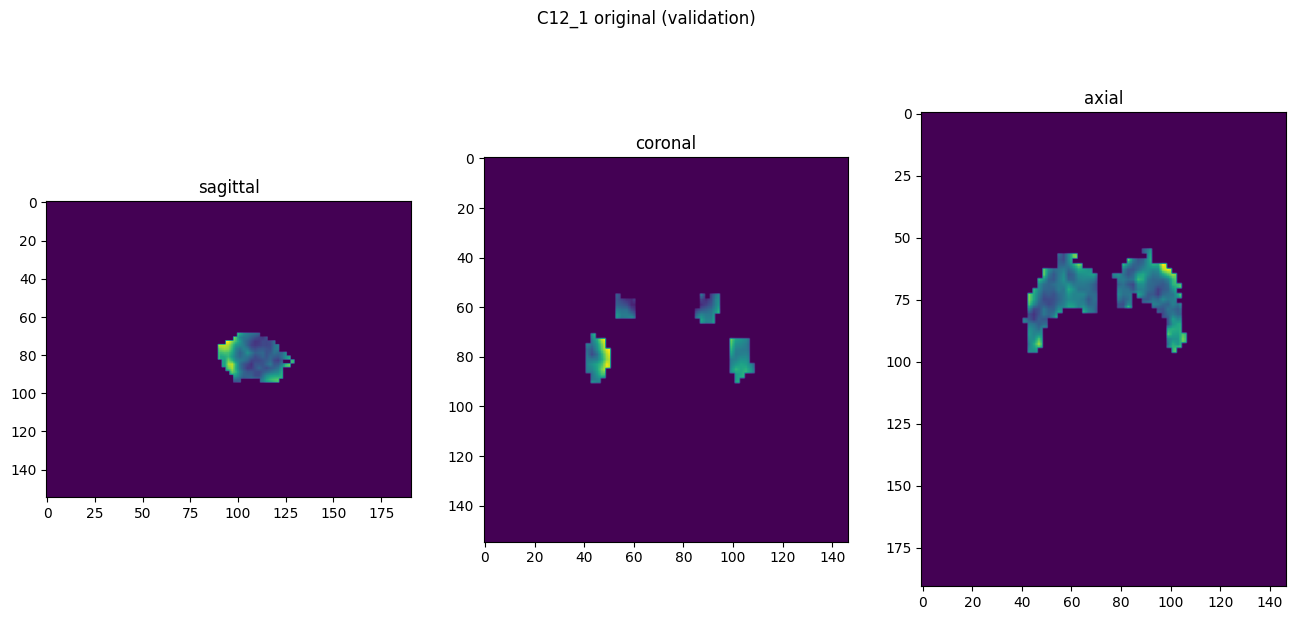

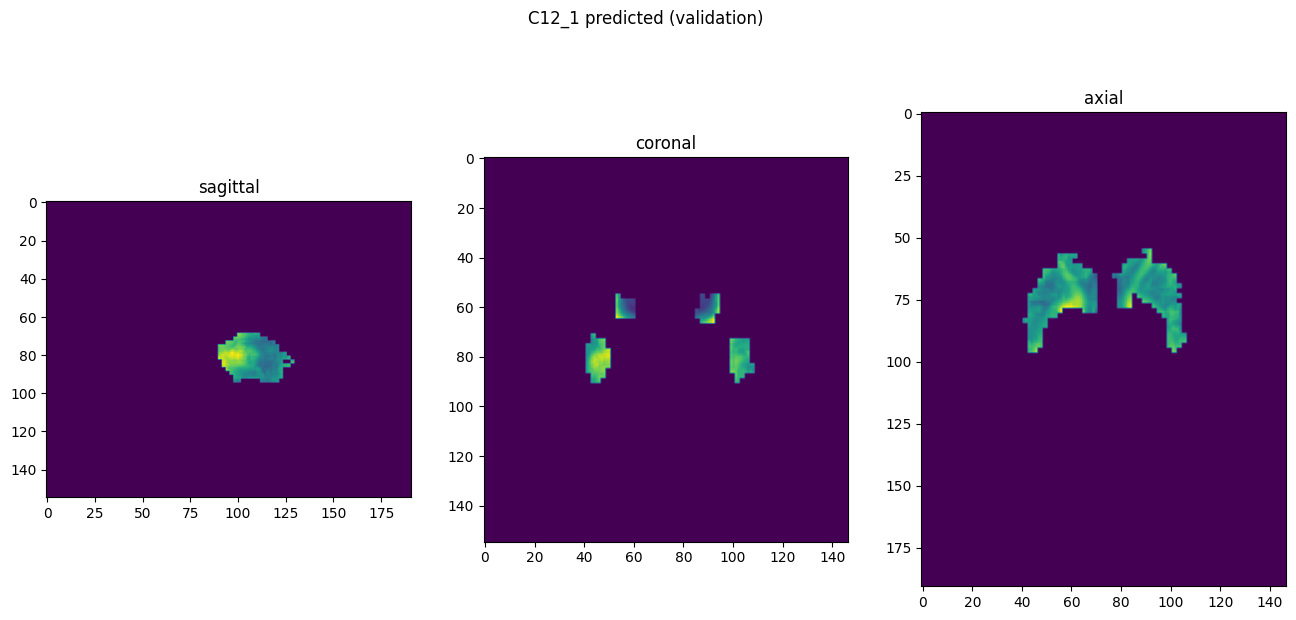

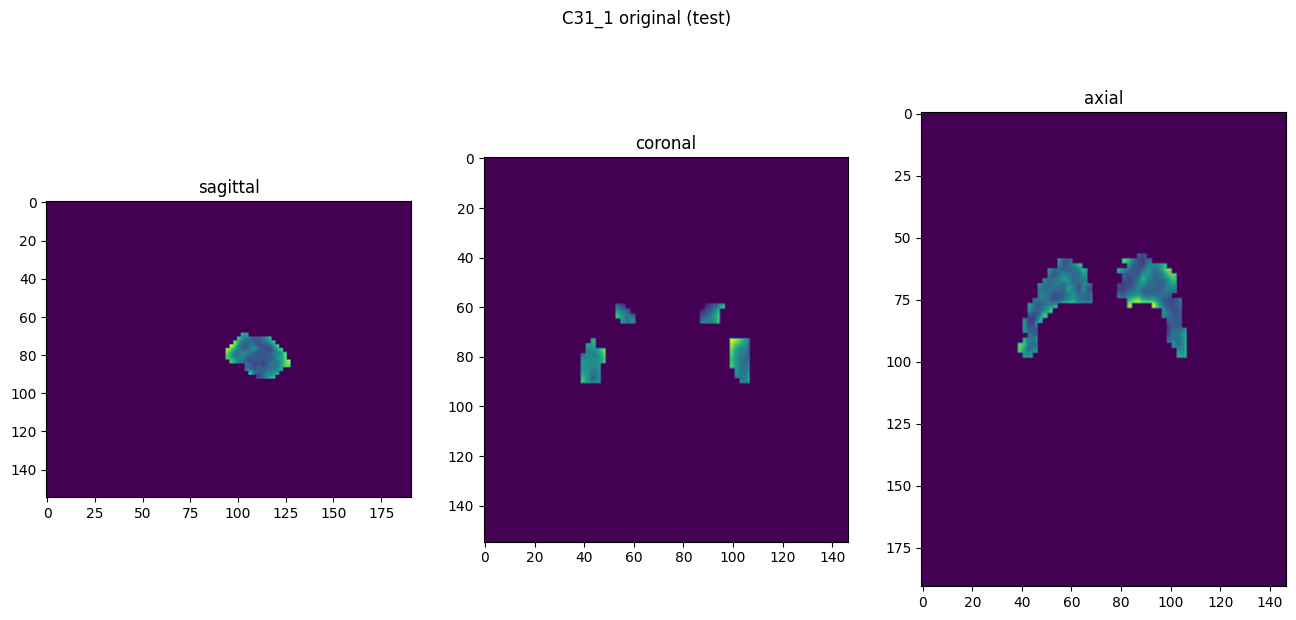

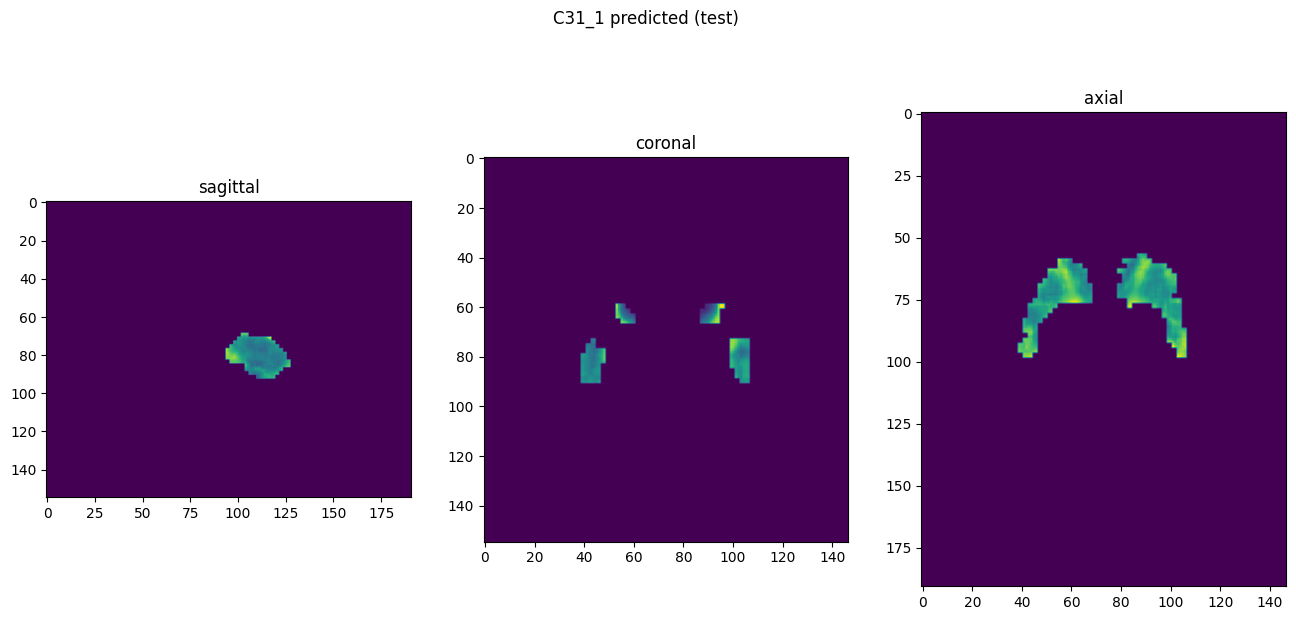

In [10]:
showResults(model, gen, threshold=None, background=False)